<a href="https://colab.research.google.com/github/dkant000/ML_PROJECT/blob/UrbansoundDetect/URBAN_SOUND_preprocess_and_ModelImplementation%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from librosa import display
import librosa
import IPython.display
import glob

In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
create basedir path to where the urban sounds folder is saved in your drive

'''
basedir = '/content/drive/MyDrive/data'

In [ ]:
'''
Paths for .csv metafile

'''

# df = pd.read_csv(os.path.join(basedir, 'UrbanSound8K.csv'))

In [ ]:
'''
if uploaded the file to google drive:
load in the data set from external url
WARNING: takes around 15 minutes to run
'''

# import urllib.request
# urllib.request.urlretrieve ("https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz","a.tar.gz")
# import tarfile
# tar = tarfile.open("a.tar.gz")
# tar.extractall()
# tar.close()

### Creating .pkl files to compile information from Librosa

**Creating .pkl files** <br>
We can further read all files with Librosa and put sample rate and sample numbers into lists and create one dataframe with them. To avoid reading all sounds with Librosa, we can save created dataframe into pickle type files. It allows to read dataframe directly from pickle files whenever we want toinstead of reading with Librosa each time.

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# sr_list = []
# y_list = []
# name_list = []


# for no, file in enumerate(sounds):
#   if no%500 == 0:
#     print('currently at: ' + str(no))

#   y, sr = librosa.load(file)

#   name = file.split('/')[-1]


#   sr_list.append(sr)
#   y_list.append(y)
#   name_list.append(name)


# # creating dataframe with extracted sound information
# sounds_df = pd.DataFrame({
#     'name': name_list,
#     'sr': sr_list,
#      'y': y_list})

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# # joining metafile information with extracted sample info
# sounds_df = sounds_df.join(df.set_index('slice_file_name'), on='name')

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# sounds_df.tail()

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 
# # to put data frames into pickle files for later
# for i in np.arange(1,11):
#   sounds_df[sounds_df['fold'] == i].to_pickle('fold'+str(i)+'.pkl')
#   print(i)

This is how to read pickle files from Google Drive. Please upload to your drive instead of colab directly. If you have mounted drive with files, reading them wont take longer than a minute. The link for files: <br>
https://drive.google.com/file/d/1cLkb3GCUI-QU4RM5N0qH4M7ivesQQS9O/view?usp=sharing

In [ ]:
'''
Paths of .pkl files

'''
pickle_files_path = '/content/drive/MyDrive/data/data_pkl/'

In [ ]:
'''
creates dataframe "df_urban_sounds" with information about samples
also creates 10 different dataframes "df_fold1, df_fold2, etc" for each fold
'''
appended_data = []
for i in np.arange(1,11):
  vars()['df_fold' + str(i)] = pd.read_pickle(pickle_files_path + 'fold' + str(i) + '.pkl')
  print(i)
  appended_data.append(vars()['df_fold' + str(i)])
df_urban_sounds = pd.concat(appended_data, ignore_index=True)

1
2
3
4
5
6
7
8
9
10


In [ ]:
'''
Created dataframe contains information about samples, where columns "sr" is sample rate and "y" is a list of recorded samples
'''
df_urban_sounds.head()

,name,sr,y,fsID,start,end,salience,fold,classID,class
0,101415-3-0-2.wav,22050,"[-0.00011783496, -0.00017157062, -0.0001774939...",101415,1.000000,5.000000,1,1,3,dog_bark
1,101415-3-0-8.wav,22050,"[0.23950581, 0.35340017, 0.29654667, 0.2917560...",101415,4.000000,8.000000,1,1,3,dog_bark
2,103074-7-0-2.wav,22050,"[0.0081740115, -0.0015046991, -0.0086963875, -...",103074,4.341279,8.341279,1,1,7,jackhammer
3,102842-3-1-0.wav,22050,"[0.007395301, 0.00981416, 0.00828659, 0.008712...",102842,113.061785,117.061785,2,1,3,dog_bark
4,101415-3-0-3.wav,22050,"[-0.0006034802, -0.0010423105, -0.0008373572, ...",101415,1.500000,5.500000,1,1,3,dog_bark


In [ ]:
# example 1. using full "df_urban_sounds"
print('Sample name:')
print(df_urban_sounds.iloc[0]['name'])
print('\n Sample rate:')
print(df_urban_sounds.iloc[0]['sr'])
print('\n Number of samples:')
print(df_urban_sounds.iloc[0]['y'])

Sample name:
101415-3-0-2.wav

 Sample rate:
22050

 Number of samples:
[-0.00011783 -0.00017157 -0.00017749 ... -0.04598654 -0.04624664
 -0.05089863]


In [ ]:
# example 2. using "df_fold1"
print('Sample name:')
print(df_fold1.iloc[0]['name'])
print('\n Sample rate:')
print(df_fold1.iloc[0]['sr'])
print('\n Number of samples:')
print(df_fold1.iloc[0]['y'])

Sample name:
101415-3-0-2.wav

 Sample rate:
22050

 Number of samples:
[-0.00011783 -0.00017157 -0.00017749 ... -0.04598654 -0.04624664
 -0.05089863]


In [ ]:
'''
Calcualting sample exact length of the samples by dividing frame rate and number of frames
'''

duration_list = []
for i in range(df_urban_sounds.shape[0]):
  dur = len(df_urban_sounds.iloc[i]['y'])/df_urban_sounds.iloc[i]['sr']
  duration_list.append(dur)

# adding new column of lengths
df_urban_sounds['length'] = duration_list

df_urban_sounds.tail()

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
8727,99192-4-0-53.wav,22050,"[0.059988726, 0.061065044, 0.16498338, 0.14804...",99192,26.5,30.5,1,10,4,drilling,4.0
8728,99192-4-0-55.wav,22050,"[0.01473959, 0.022773646, 0.05025508, 0.058404...",99192,27.5,31.5,1,10,4,drilling,4.0
8729,99192-4-0-54.wav,22050,"[0.005095922, 0.014739645, 0.011429922, -0.000...",99192,27.0,31.0,1,10,4,drilling,4.0
8730,99192-4-0-52.wav,22050,"[-0.008036119, -0.019243455, -0.013388598, 0.0...",99192,26.0,30.0,1,10,4,drilling,4.0
8731,99192-4-0-7.wav,22050,"[0.024699196, 0.0069064884, 0.03016094, 0.0363...",99192,3.5,7.5,1,10,4,drilling,4.0


## Data Preprocessing

We need to create a feature set of the wav files for our model to use and split into training/validation/test sets.
In the given example (https://github.com/AmritK10/Urban-Sound-Classification/blob/master/Urban_data_preprocess.ipynb), the features used are:

- MFCCs - Mel-frequency cepstral coefficients
- Melspectrogram
- Chromagram
- Constant-Q chromagram
- Chroma Energy Normalized (CENS)

Each of these features give data values about each sound (and therefore qualities that make each category recognisable) and can be used as input to train our models. We can use a loop to iterate over each file, and store these values (using numpy.vstack to compile all of these features for each sound) for that wav file along with the label. To calculate the feature values, we can use the corresponding librosa functions.

May also need to do some data balancing for 'car horn' and 'gunshot' which have fewer wav files (data augmentation maybe).

In [ ]:
# Example how it is possible to access metrics provided for any .wav sound sample

# It uses created dataframe from .pkl files

# information from "fold_1" dataframe.
sr, y = df_fold1.iloc[0]['sr'], df_fold1.iloc[0]['y']

# # metrics taken from GitHub link mentioned above
# mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40) # MFCCs
# melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000) # Melspectogram
# chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40) # Chromagram
# chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=36) # Constant-Q chromagram. n_chroma adjusted to 36
# chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=36) # Chroma Energy Normalized. n_chroma adjusted to 36

### 1. Data Augmentation

We have far fewer samples of 'car_horn' and 'gun_shot' so will perform some data augmentation to create more data on which to train our model. 

In [ ]:
#Data Augmentation

#several options for data augmentation - add white noise, adjust pitch, time shifting
#aim to keep the sounds recognisable (don't distort too much)
#used from https://www.kaggle.com/mpwolke/who-let-the-dogs-out-wav

def pitch(data):
    """
    Adjusts pitch.
    """
    sample_rate =  22050
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data


def white_noise(data):
    """
    Adding White Noise
    """
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data


In [ ]:
#example of pitch change

sr_car, y_car = df_urban_sounds.iloc[328]['sr'], df_urban_sounds.iloc[328]['y']       #car horn sound

#original sound
IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
#car horn after pitch change

x = pitch(y_car)
IPython.display.Audio(x, rate=sr_car)

In [ ]:
#car horn after white noise added

x = white_noise(y_car)
IPython.display.Audio(x, rate=sr_car)

In [ ]:
def augmenter(df):
  """
  Adding White Noise and adjusting pitch - apply to dataframe column 'y'
  """
  df['y'] = df['y'].apply(white_noise)
  df['y'] = df['y'].apply(pitch)
  return df

In [ ]:
'''
Here we calculate weights for each fold. 
We want to ensure that the folds have a maintain a roughly even distribution of proportions of classes after augmentation
Focus will be on adding white noise to produce new samples of 'gun_shot' and 'car_horn' to fix the data imbalance.
Note that the names and times of these new sound files don't matter as they are not used in training the models.
'''
# number of samples
no_gs = df_urban_sounds['class'].value_counts()['gun_shot'] # 374
no_ch = df_urban_sounds['class'].value_counts()['car_horn'] # 429
no_s = df_urban_sounds['class'].value_counts()['siren'] # 929

# arrays of rows number which will be added to each fold
gsarr = []
charr = []

temp = df_urban_sounds[(df_urban_sounds['class'] != 'car_horn') & (df_urban_sounds['class'] != 'gun_shot')].copy()
for i in np.arange(1,9): # only 8 folds because we balance only training set
  avg = np.average(temp[temp['fold'] == i]['class'].value_counts())
  avg = int(round(avg))

  no1 = len(df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'gun_shot')])
  no2 = len(df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')])

  if no1<avg:
    gsarr = np.append(gsarr, avg - no1).astype(int)
  if no2<avg:
    charr = np.append(charr, avg - no2).astype(int)

In [ ]:
gs_aug_df = pd.DataFrame()
ch_aug_df = pd.DataFrame()

# pick random row. "replace = True" allows to take the same row multiple times (we use that because there are more than 500 'missing' samples). 
#The changes are also random so it is highly unlikely that a change will be repeated.

for i in np.arange(1,9):
  gs_aug = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'gun_shot')].sample(n=gsarr[i-1], replace = True)
  gs_aug_df = gs_aug_df.append(augmenter(gs_aug))

  ch_aug = df_urban_sounds[(df_urban_sounds['fold'] == i) & (df_urban_sounds['class'] == 'car_horn')].sample(n=charr[i-1], replace = True)
  ch_aug_df = ch_aug_df.append(augmenter(ch_aug))


#append the car_horn and gun_shot noises with white noise and changed pitch added to df_urban_sounds dataframe
df_urban_sounds = df_urban_sounds.append([gs_aug_df, ch_aug_df], ignore_index=True)

In [ ]:
df_urban_sounds.tail() 
# 9659 rows, similar to what we would expect since fold9 and fold10 have imbalanced for 2 classes (so approx 10000-2*2*100)

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
9654,71309-1-0-0.wav,22050,"[0.007779911532994677, 0.014346636710678923, 0...",71309,0.406025,4.406025,2,8,1,car_horn,4.000000
9655,175852-1-0-0.wav,22050,"[0.0034768670927510497, -0.028275816130153196,...",175852,0.099252,1.234139,1,8,1,car_horn,1.130023
9656,125520-1-1-0.wav,22050,"[-0.0003486210120772869, 0.002596558078230025,...",125520,1.873410,4.051365,1,8,1,car_horn,2.177959
9657,155283-1-0-0.wav,22050,"[0.05759320011318909, 0.06222669153876007, 0.0...",155283,95.455122,96.061195,2,8,1,car_horn,0.606077
9658,71309-1-0-3.wav,22050,"[0.027593427960664677, -0.011651282108276166, ...",71309,1.906025,5.906025,2,8,1,car_horn,4.000000


We can check the white noise and pitch changes were applied:

In [ ]:
#finding instances with the same name and listening to audio
df_urban_sounds[df_urban_sounds.name == '107090-1-1-0.wav']

,name,sr,y,fsID,start,end,salience,fold,classID,class,length
6275,107090-1-1-0.wav,22050,"[-0.0050713373, -0.02095482, -0.03342774, -0.0...",107090,29.715744,30.54502,2,8,1,car_horn,0.829297


In [ ]:
sr_car, y_car = df_urban_sounds.iloc[6275]['sr'], df_urban_sounds.iloc[6275]['y']       #car horn sound with added white noise

IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
sr_car, y_car = df_urban_sounds.iloc[9626]['sr'], df_urban_sounds.iloc[9626]['y']       #car horn sound with added white noise and pitch change

IPython.display.Audio(y_car, rate=sr_car)

In [ ]:
sr_car, y_car = df_urban_sounds.iloc[9657]['sr'], df_urban_sounds.iloc[9657]['y']       #car horn sound with added white noise and pitch change

IPython.display.Audio(y_car, rate=sr_car)

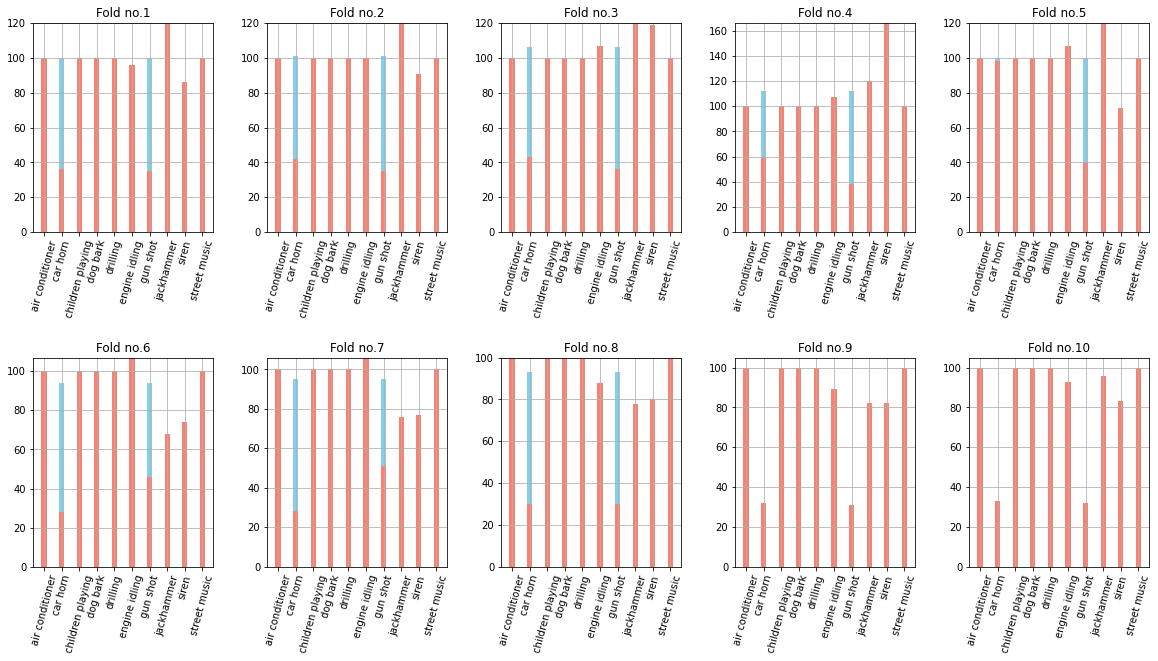

In [ ]:
'''
Plotting imbalanced folds with additional rows to balance them
'''
# labels sorted by classID
class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

df_withoutWN = df_urban_sounds[:8732]
df_withWN = df_urban_sounds[8732:]

df_empty = pd.Series(data=np.repeat(0,8), index=np.array([0,2,3,4,5,7,8,9])) # for other 8 classes

width = 0.3

for i in np.arange(1,11):
  vals = df_withoutWN[df_withoutWN['fold'] == i]['classID'].value_counts().sort_index().values
  if i <= 8:
    vals2 = df_withWN[df_withWN['fold'] == i]['classID'].value_counts()
    vals2 = vals2.append(df_empty).sort_index().values

  ax = fig.add_subplot(2, 5, i)
  ax.bar(class_labels, vals, width, label='Before', color = 'salmon')
  if i <= 8:
    ax.bar(class_labels, vals2, width,bottom=vals, label='After', color='skyblue')

  plt.title('Fold no.' + str(i))
  plt.xticks(rotation=75)
  plt.grid()
  
plt.show()

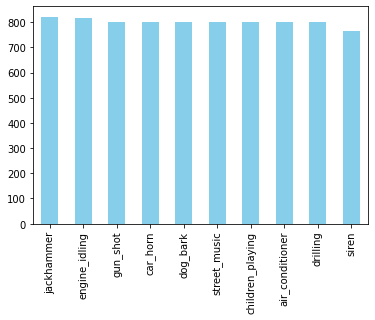

In [ ]:
# folds until 8
class_counts = df_urban_sounds[(df_urban_sounds['fold'] != 9) & (df_urban_sounds['fold'] != 10)]['class'].value_counts(sort=True)
class_counts.plot.bar(color = 'skyblue')

###  2. Creating Feature Set and splitting the data

In [ ]:
#go for approx 80/20 train/test split using folds (allocate folds 9 and 10 as test data)

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# x_train=[]
# x_test=[]
# y_train=[]
# y_test=[]


# #iterate over each row
# #for each row get features of the sound, and compile into single array
# #perform train test split - 80/20
# for index, row in tqdm(df_urban_sounds.iterrows()):

#     fold = df_urban_sounds.iloc[index]["fold"]
#     label= df_urban_sounds.iloc[index]['classID']
#     sr, y = df_urban_sounds.iloc[index]['sr'], df_urban_sounds.iloc[index]['y']

#     mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T, axis = 0) # MFCCs
#     melspectrogram =np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T, axis = 0) # Melspectogram
#     chroma_stft= np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T, axis = 0) # Chromagram
#     chroma_cq =np.mean(librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=40, bins_per_octave=40).T, axis = 0) # Constant-Q chromagram. bins_per_octave adjusted to 40
#     chroma_cens =np.mean(librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=40, bins_per_octave=40).T, axis = 0) # Chroma Energy Normalized. bins_per_octave adjusted to 40

#     #print(melspectrogram.shape,chroma_stft.shape,chroma_cq.shape,chroma_cens.shape,mfccs.shape)
#     features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(40,5))
#     if(fold != 9 and fold != 10):
#       x_train.append(features)
#       y_train.append(label)
#     else:
#       x_test.append(features)
#       y_test.append(label)

In [ ]:
# len(x_train)+len(x_test)

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# #Models require the training/test data to be in the form of arrays
# #convert from list to arrays

# x_train_array =np.array(x_train)
# x_test_array  =np.array(x_test)
# y_train_array =np.array(y_train)
# y_test_array  =np.array(y_test)
# print(x_train_array.shape,x_test_array.shape,y_train_array.shape,y_test_array.shape)

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# #reshaping into 2d to save in csv format so that we do not need to rerun the above cells
# x_train_2d=np.reshape(x_train_array,(x_train_array.shape[0],x_train_array.shape[1]*x_train_array.shape[2]))
# x_test_2d=np.reshape(x_test_array,(x_test_array.shape[0],x_test_array.shape[1]*x_test_array.shape[2]))
# x_train_2d.shape,x_test_2d.shape

In [ ]:
# # DO NOT RUN THIS CODE BLOCK! 

# #saving the csv file (Share with group so that they do not have to rerun the above code themselves)
# np.savetxt("train_data.csv", x_train_2d, delimiter=",")
# np.savetxt("test_data.csv",x_test_2d,delimiter=",")
# np.savetxt("train_labels.csv",y_train,delimiter=",")
# np.savetxt("test_labels.csv",y_test,delimiter=",")

The train and test data is saved into csv files so that the above code does not have to be rerun. Here is the link to the files for you to download to your Drive:

https://drive.google.com/drive/folders/1CJ2jS9j4VWNv7f79nNl8lhIcErMAyT0o?usp=sharing





# Model Implementation & Optimisation



We need to develop several different models for comparison. Some variations of our own i.e. trialling different layers. Also use at least one pre-made model(e.g. AlexNet) for comparison, and perhaps another from a literature review that has been tried before on this dataset.

In [ ]:
# All libraries
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap
import keras
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout,Activation, Conv2D, Conv1D
from keras.layers import MaxPooling2D, Flatten, TimeDistributed, Reshape
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import matplotlib.gridspec as gridspec


In [ ]:
'''
Paths for splitted train/test datasets
Uncomment your path
'''

traintest_dir = '/content/drive/MyDrive/data/raw_data/'

In [ ]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

x_train = pd.read_csv(os.path.join(traintest_dir, 'train_data.csv'), header= None)
y_train = pd.read_csv(os.path.join(traintest_dir, 'train_labels.csv'), header = None)
x_test = pd.read_csv(os.path.join(traintest_dir, 'test_data.csv'), header = None)
y_test = pd.read_csv(os.path.join(traintest_dir, 'test_labels.csv'), header = None)

# fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

#convert back to numpy arrays 
# x_train = x_train.to_numpy()
# y_train = y_train.to_numpy()
# x_test = x_test.to_numpy()
# y_test = y_test.to_numpy()

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(8006, 200) (8006, 10) (1653, 200) (1653, 10)


We aim to have reproducible results, thus we set seed for random variables. The idea and code was implemented from: <br>
https://stackoverflow.com/questions/48631576/reproducible-results-using-keras-with-tensorflow-backend

In [ ]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value) # tensorflow 2.x
# tf.set_random_seed(seed_value) # tensorflow 1.x

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
'''
This function produces:
1) dataframe of micro and macro precision, recall, F1-score metrics
2) overall accuracy
3) individual recall values per class
4) individual precision values per class
'''

def my_results(y_true, y_pred):
  preds = np.zeros_like(y_pred)
  preds[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
  matrix = confusion_matrix(y_true.argmax(axis=1), preds.argmax(axis=1))

  # accuracy
  acc = accuracy_score(y_true, preds)

  # recal, precision for each class
  recall_classes = recall = np.diag(matrix) / np.sum(matrix, axis = 1)
  precision_classes = precision = np.diag(matrix) / np.sum(matrix, axis = 0)

  # micro. precision and recall should be the same!
  f1_micro = f1_score(y_test, preds, average="micro")
  precision_micro = precision_score(y_test, preds, average="micro")
  recall_micro = recall_score(y_test, preds, average="micro")

  # macro
  f1_macro = f1_score(y_test, preds, average="macro")
  precision_macro = precision_score(y_test, preds, average="macro")
  recall_macro = recall_score(y_test, preds, average="macro")

  # writing to df
  res = {'Precision': [precision_micro, precision_macro], 'Recall': [recall_micro, recall_macro], 'F1-score': [f1_micro, f1_macro]}
  mydf = pd.DataFrame(data=res, index=['Micro', 'Macro'])

  return mydf, acc, recall_classes, precision_classes


In [ ]:
'''
This function produces:
1) number of class counts alongside number of prediction counts per classes
2) piecharts of individual accuracy for ten class targets
'''

def plot_counts_accuracy(y_true, y_pred):
  # get prediction array
  preds = np.zeros_like(y_pred)
  preds[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

  # counts of predictions per class
  pred_classes = preds.sum(axis=0)
  true_classes = y_true.sum(axis=0)

  # number of accurate predictions per class
  accurate_preds = ((y_true == preds) & (y_true == 1)).sum(axis=0)

  # accuracy by class
  acc_class = accurate_preds/true_classes

  # class labels by ID order
  class_labels = ["air conditioner", "car horn", "children playing", 
                "dog bark", "drilling", "engine idling", "gun shot", 
                "jackhammer", "siren", "street music"]

  # legends
  legends=['True','Pred.']

  # labels range for x-axis
  pos = np.arange(len(class_labels))

  # plot
  fig = plt.figure(figsize=(15, 5))
  gridspec.GridSpec(2, 8)
  plt.subplot2grid((2,8), (0,0), colspan=3, rowspan=2)
  
  plt.bar(pos, true_classes,color='black', edgecolor='black', alpha=0.8, width=0.3)
  plt.bar(pos+0.3, pred_classes,color='red', edgecolor='black', alpha=0.6, width=0.3)
  plt.xticks(pos, class_labels, rotation=70)
  plt.ylabel('Class counts', fontsize=12)
  plt.title('Number of true and predicted classes',fontsize=14, y=1.03)
  plt.legend(legends,loc=2)
  plt.grid()

  size = 0.3

  colors = ['cornflowerblue', 'gainsboro']

  for i in range(3,8):
    plt.subplot2grid((2,8), (0,i))
    acc = acc_class[i-3]
    wedges, labels_coord = plt.pie([acc, 1-acc], colors = colors, radius=1, startangle=90, wedgeprops=dict(width=size, edgecolor='w'))
    plt.text(-0.5, -0.1, '{:.0%}'.format(acc), fontsize=18)
    lbl = class_labels[i-3]
    plt.title(lbl)

  for i in range(3,8):
    plt.subplot2grid((2,8), (1,i))
    acc = acc_class[5+i-3]
    wedges, labels_coord = plt.pie([acc, 1-acc], colors = colors, radius=1, startangle=90, wedgeprops=dict(width=size, edgecolor='w'))
    plt.text(-0.5, -0.1, '{:.0%}'.format(acc), fontsize=18)
    lbl = class_labels[5+i-3]
    plt.title(lbl)

  fig.suptitle('Accuracy per class', size=14, y=0.94, x=0.65)

  plt.show()

  return

# OUR Model

## Simple CNN [Proposed]

In [ ]:
'''
Simple CNN model.

This is basic CNN model, where only Dense layer with dropout rates were used.

We used hyperparameter tuning to optimise model's performance.
'''


tf.random.set_seed(seed_value) # to get reproducible results

model=Sequential()

###first layer
model.add(Dense(100,input_shape=(None,200)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()
#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, None, 100)         20100     
_________________________________________________________________
activation_4 (Activation)    (None, None, 100)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 200)         20200     
_________________________________________________________________
activation_5 (Activation)    (None, None, 200)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 100)        

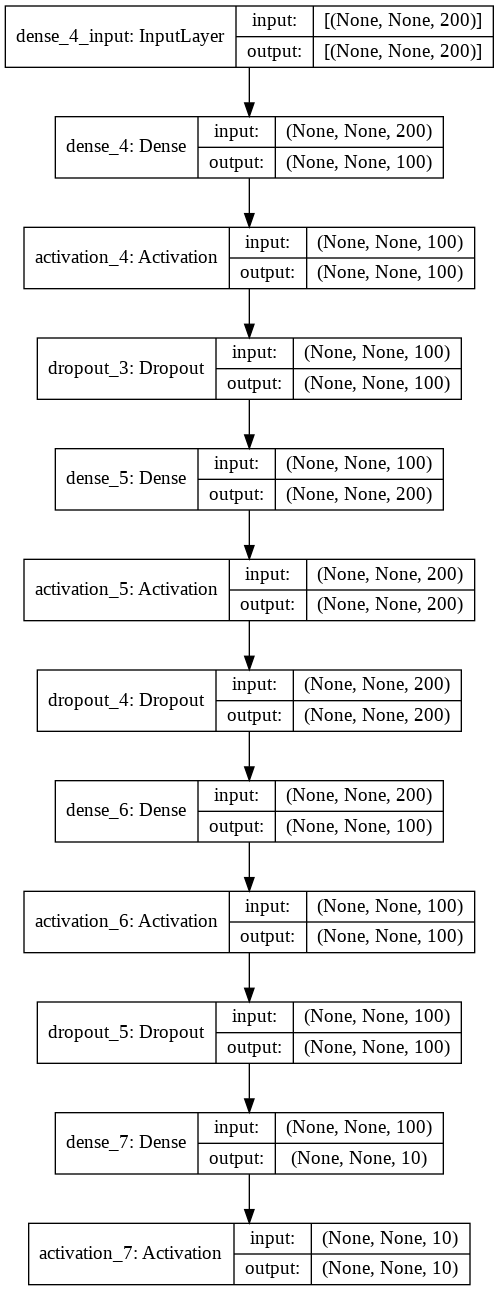

In [ ]:
# Display internal structure of layers and nodes

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
# model fitting
history = model.fit(x_train,y_train,epochs=30,validation_data=(x_test,y_test),batch_size=25)

Epoch 1/30
321/321 [==============================] - 1s 2ms/step - loss: 2.2467 - accuracy: 0.1712 - val_loss: 2.0933 - val_accuracy: 0.1936
Epoch 2/30
321/321 [==============================] - 1s 2ms/step - loss: 1.9047 - accuracy: 0.2953 - val_loss: 1.9471 - val_accuracy: 0.3091
Epoch 3/30
321/321 [==============================] - 1s 2ms/step - loss: 1.7612 - accuracy: 0.3616 - val_loss: 1.7786 - val_accuracy: 0.3944
Epoch 4/30
321/321 [==============================] - 1s 2ms/step - loss: 1.6402 - accuracy: 0.4181 - val_loss: 1.6727 - val_accuracy: 0.4610
Epoch 5/30
321/321 [==============================] - 1s 2ms/step - loss: 1.5163 - accuracy: 0.4718 - val_loss: 1.5934 - val_accuracy: 0.4701
Epoch 6/30
321/321 [==============================] - 1s 2ms/step - loss: 1.4277 - accuracy: 0.5195 - val_loss: 1.5310 - val_accuracy: 0.5064
Epoch 7/30
321/321 [==============================] - 1s 2ms/step - loss: 1.3895 - accuracy: 0.5217 - val_loss: 1.5344 - val_accuracy: 0.4955
Epoch 

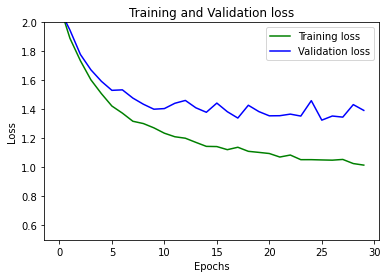

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.5,2)
plt.legend()
plt.show()

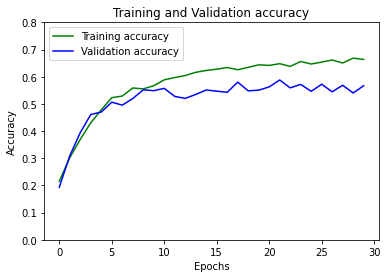

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,0.8)
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(x_test)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.566848  0.566848  0.566848
Macro   0.608361  0.597716  0.586898
***********************************************

Accuracy: 0.5668481548699335
***********************************************

Precision by class: [0.64948454 0.87719298 0.36467236 0.62200957 0.36842105 0.73595506
 0.44036697 0.56790123 0.70930233 0.74829932]


Recall by class: [0.315      0.76923077 0.64       0.65       0.315      0.71978022
 0.76190476 0.51685393 0.73939394 0.55      ]


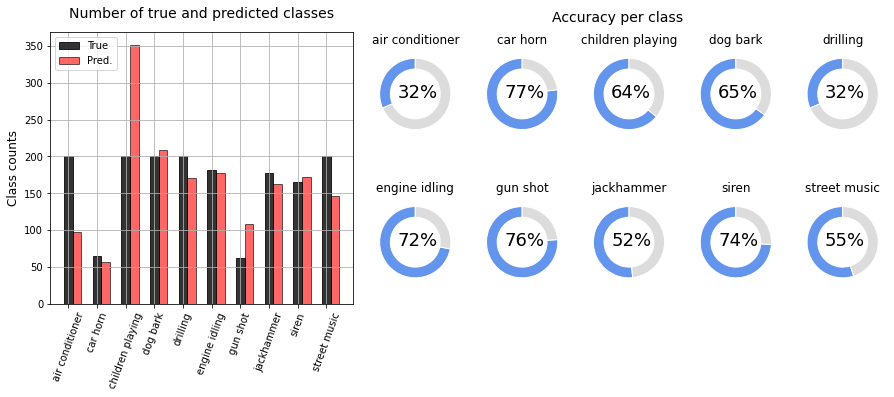

In [ ]:
plot_counts_accuracy(y_test, y_pred)

#### Hyperparameter Tuning

*Hyperparameters are the variables which determines the network structure(Eg: Number of Hidden Units) and the variables which determine how the network is trained(Eg: Learning Rate).*

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV 
from keras.wrappers.scikit_learn import KerasClassifier

def DL_Model(activation= "rlue", optimizer='Adam'):
    model = Sequential()
    model.add(Dense(100, input_shape= (None,200), activation= activation))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation= activation))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation= activation))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# Definying grid parameters
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
# neurons = [100, 125, 150, 200, 225, 250]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs=30, batch_size=50, verbose= 0)

model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(x_train,y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

Max Accuracy Registred: 0.542 using {'activation': 'relu', 'optimizer': 'Adam'}


## Complex CNN [*Proposed*]

In [ ]:
# Temporary reshaping for better understanding
Xtr = x_train.reshape(x_train.shape[0], 40, 5) # to differentiate 5 features
Xte = x_test.reshape(x_test.shape[0], 40, 5)

XtrCNN = Xtr.reshape(Xtr.shape[0], Xtr.shape[1], Xtr.shape[2], 1)
XteCNN = Xte.reshape(Xte.shape[0], Xte.shape[1], Xte.shape[2], 1)

print(XtrCNN.shape, Xte.shape, y_train.shape, y_test.shape)

(8006, 40, 5, 1) (1653, 40, 5) (8006, 10) (1653, 10)


In [ ]:
'''
Complex CNN model.

We tried to add more complexity for CNN in hopes of achieving better results
in comparison to Simple CNN model.

The following model was examined on different parameters:
1) Conv2D layers were tuned for : 64, 128, 256 and 512 no of neurons.
2) Activation functions tried: ReLU, LeakyReLU, tanh
3) Different number of dense layers examined to measure models depth vs width capabilities
4) Adding additional droupout layers with rate of: 0.1, 0.3, 0.4

Based on model efficiency and computational speed, the following model was concluded.
'''

tf.random.set_seed(seed_value) # to get reproducible results

# model
model=Sequential()

#building the model
model.add(Conv2D(64, kernel_size = 5, strides=(1, 1), activation="relu", 
                 padding="same", input_shape=(XtrCNN.shape[1], XtrCNN.shape[2], 1)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
# model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
# model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=700,activation='relu'))
model.add(Dense(units=600,activation='relu'))
model.add(Dense(units=500,activation='relu'))
model.add(Dense(units=400,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 40, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 2, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 2, 64)         102464    
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 2, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 2, 64)         102464    
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 2, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2560)             

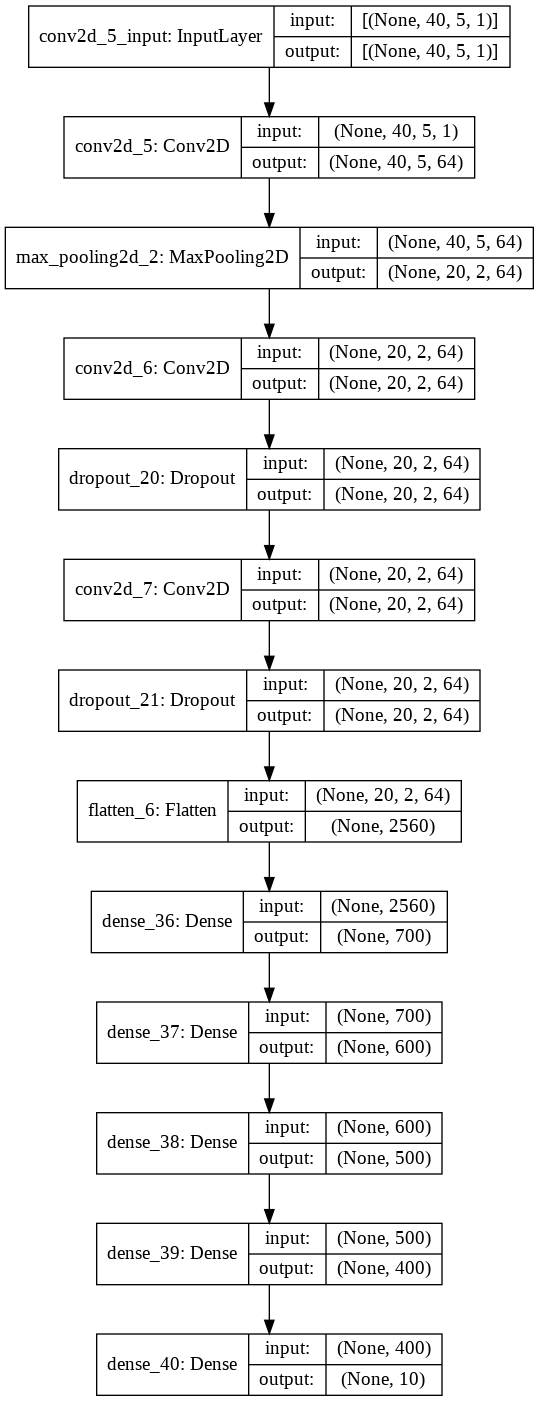

In [ ]:
# Display internal structure of layers and nodes

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
# model fitting
history = model.fit(XtrCNN,y_train,epochs=30,validation_data=(XteCNN, y_test), batch_size=30)

Epoch 1/30
267/267 [==============================] - 26s 96ms/step - loss: 2.0457 - accuracy: 0.2210 - val_loss: 1.6692 - val_accuracy: 0.3291
Epoch 2/30
267/267 [==============================] - 26s 96ms/step - loss: 1.3028 - accuracy: 0.5287 - val_loss: 1.3005 - val_accuracy: 0.5451
Epoch 3/30
267/267 [==============================] - 26s 97ms/step - loss: 0.9877 - accuracy: 0.6563 - val_loss: 1.4293 - val_accuracy: 0.5354
Epoch 4/30
267/267 [==============================] - 26s 96ms/step - loss: 0.8026 - accuracy: 0.7267 - val_loss: 1.3080 - val_accuracy: 0.6177
Epoch 5/30
267/267 [==============================] - 26s 97ms/step - loss: 0.6128 - accuracy: 0.7943 - val_loss: 1.5505 - val_accuracy: 0.5711
Epoch 6/30
267/267 [==============================] - 26s 97ms/step - loss: 0.5650 - accuracy: 0.8120 - val_loss: 1.3566 - val_accuracy: 0.6509
Epoch 7/30
267/267 [==============================] - 26s 96ms/step - loss: 0.4625 - accuracy: 0.8470 - val_loss: 1.3204 - val_accuracy:

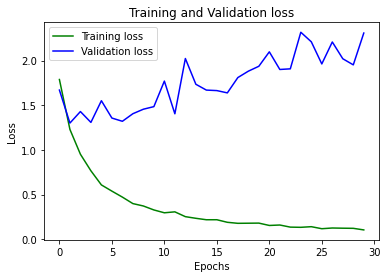

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

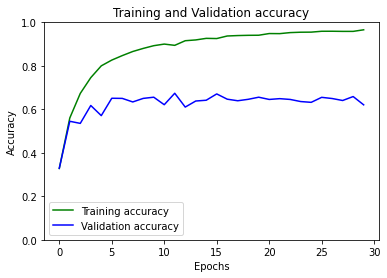

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteCNN)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.620690  0.620690  0.620690
Macro   0.640808  0.639556  0.621011
***********************************************

Accuracy: 0.6206896551724138
***********************************************

Precision by class: [0.65263158 0.52941176 0.66976744 0.61946903 0.39252336 0.90721649
 0.62686567 0.61682243 0.80555556 0.58781362]


Recall by class: [0.31       0.83076923 0.72       0.7        0.42       0.48351648
 0.66666667 0.74157303 0.7030303  0.82      ]


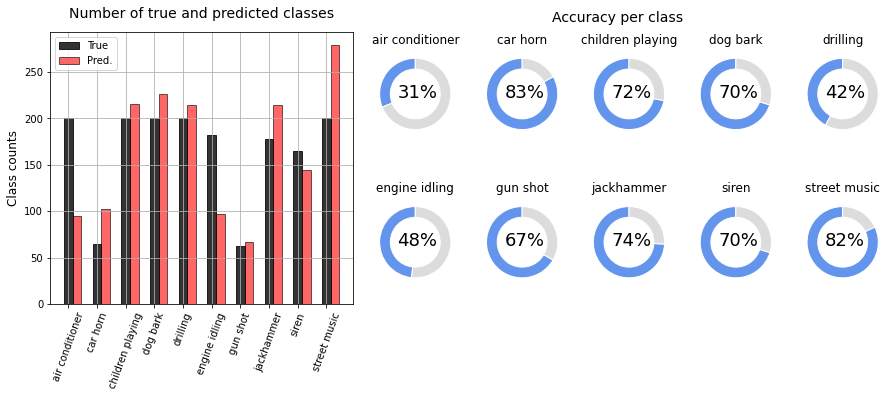

In [ ]:
plot_counts_accuracy(y_test, y_pred)

## Recurrent Neural Network [Proposed]

In [ ]:
'''
RNN model

We tried to implement significantly complex model for multiclass classification problem.

The following model was examined on different parameters:
1) LSTM layers were tuned for : 64, 128, 256 and 512 no of neurons.
2) Adding additional Desne, LSTM layers
2) Activation functions tried: ReLU, LeakyReLU, tanh
3) Droupout rate tuned for: 0.1, 0.2, 0.3, 0.4, 0.5

Based on model efficiency and , the following model was concluded.
'''

tf.random.set_seed(seed_value) # to get reproducible results

model = Sequential()
model.add(LSTM(
        256,
        input_shape=(40,5),
        return_sequences=True
    ))
model.add(Dropout(0.3))
model.add(LSTM(512,return_sequences=True))
model.add(Dropout(0.3))
# model.add(LSTM(256,))
# model.add(Dense(256))
# model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(512,  activation="relu")))
model.add(TimeDistributed(Dense(512, activation="relu")))
model.add(TimeDistributed(Dense(256,  activation="relu")))
model.add(TimeDistributed(Dense(256, activation="relu")))
model.add(Flatten())
model.add(Dense(10))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='ADAM',metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 40, 256)           268288    
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 40, 512)           1574912   
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 40, 512)           262656    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 40, 512)           262656    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 40, 256)          

In [ ]:
# model fitting

start = datetime.now()

history = model.fit(XtrLSTM, y_train, validation_data=(XteLSTM, y_test), epochs=20, batch_size=30)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
267/267 [==============================] - 231s 849ms/step - loss: 1.9856 - accuracy: 0.2647 - val_loss: 1.7087 - val_accuracy: 0.3969
Epoch 2/20
267/267 [==============================] - 226s 847ms/step - loss: 1.3800 - accuracy: 0.5199 - val_loss: 1.7510 - val_accuracy: 0.4350
Epoch 3/20
267/267 [==============================] - 225s 842ms/step - loss: 1.1818 - accuracy: 0.6060 - val_loss: 1.6272 - val_accuracy: 0.5215
Epoch 4/20
267/267 [==============================] - 226s 847ms/step - loss: 0.9961 - accuracy: 0.6691 - val_loss: 1.5962 - val_accuracy: 0.5505
Epoch 5/20
267/267 [==============================] - 229s 856ms/step - loss: 0.8313 - accuracy: 0.7304 - val_loss: 1.5915 - val_accuracy: 0.5402
Epoch 6/20
267/267 [==============================] - 228s 856ms/step - loss: 0.7113 - accuracy: 0.7677 - val_loss: 1.5267 - val_accuracy: 0.5862
Epoch 7/20
267/267 [==============================] - 228s 853ms/step - loss: 0.6004 - accuracy: 0.8077 - val_loss: 1.7548 -

In [ ]:
model.evaluate(XteLSTM, y_test)

52/52 [==============================] - 10s 189ms/step - loss: 3.4021 - accuracy: 0.6013


[3.402146339416504, 0.6013309359550476]

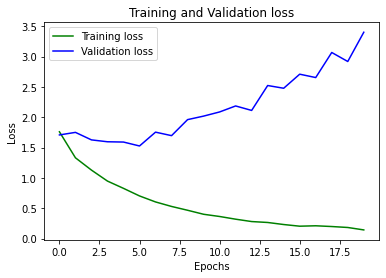

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

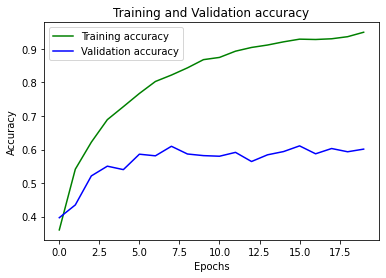

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteLSTM)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.601331  0.601331  0.601331
Macro   0.616167  0.615637  0.606630
***********************************************

Accuracy: 0.6013309134906231
***********************************************

Precision by class: [0.57692308 0.55789474 0.48484848 0.5959596  0.49171271 0.84444444
 0.63157895 0.6        0.76129032 0.61702128]


Recall by class: [0.375      0.81538462 0.72       0.59       0.445      0.62637363
 0.57142857 0.57303371 0.71515152 0.725     ]


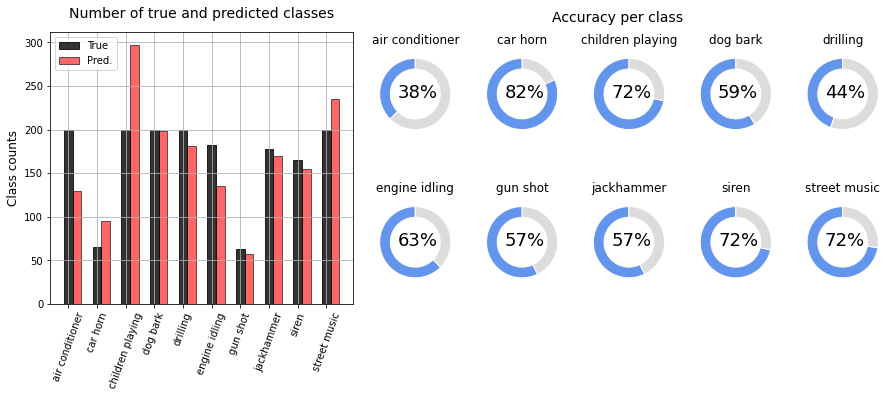

In [ ]:
plot_counts_accuracy(y_test, y_pred)

## Published CNN

In [ ]:
'''
Published CNN model
'''
tf.random.set_seed(seed_value) # to get reproducible results

#forming model
model=Sequential()

#building the model
model.add(Conv2D(64, kernel_size = 5, strides=(1, 1), activation="relu", 
                 padding="same", input_shape=(XtrCNN.shape[1], XtrCNN.shape[2], 1)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 40, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 2, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 2, 64)         102464    
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 2, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               655616    
_________________________________________________________________
dense_26 (Dense)             (None, 512)              

In [ ]:
# model fitting
history = model.fit(XtrCNN,y_train,epochs=30,validation_data=(XteCNN, y_test), batch_size=50)

Epoch 1/30
161/161 [==============================] - 11s 68ms/step - loss: 1.9097 - accuracy: 0.2851 - val_loss: 1.4998 - val_accuracy: 0.4332
Epoch 2/30
161/161 [==============================] - 11s 68ms/step - loss: 1.0902 - accuracy: 0.6268 - val_loss: 1.2339 - val_accuracy: 0.6171
Epoch 3/30
161/161 [==============================] - 11s 67ms/step - loss: 0.7676 - accuracy: 0.7445 - val_loss: 1.2696 - val_accuracy: 0.6261
Epoch 4/30
161/161 [==============================] - 11s 67ms/step - loss: 0.5698 - accuracy: 0.8145 - val_loss: 1.2854 - val_accuracy: 0.6358
Epoch 5/30
161/161 [==============================] - 11s 68ms/step - loss: 0.4370 - accuracy: 0.8559 - val_loss: 1.5459 - val_accuracy: 0.5554
Epoch 6/30
161/161 [==============================] - 11s 66ms/step - loss: 0.3830 - accuracy: 0.8707 - val_loss: 1.4928 - val_accuracy: 0.6110
Epoch 7/30
161/161 [==============================] - 11s 67ms/step - loss: 0.3014 - accuracy: 0.8991 - val_loss: 1.5429 - val_accuracy:

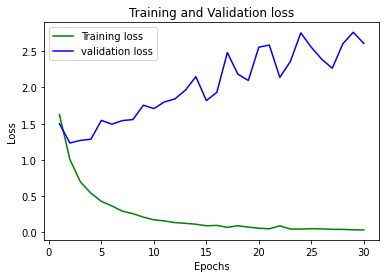

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

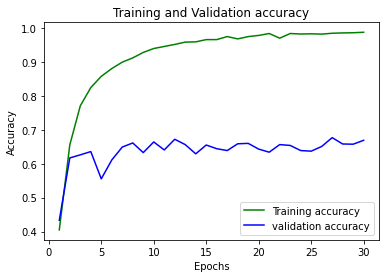

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteCNN)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.669087  0.669087  0.669087
Macro   0.690833  0.692087  0.679746
***********************************************

Accuracy: 0.6690865093768905
***********************************************

Precision by class: [0.83962264 0.79104478 0.68224299 0.6123348  0.45348837 0.90070922
 0.61445783 0.53281853 0.71428571 0.76732673]


Recall by class: [0.445      0.81538462 0.73       0.695      0.39       0.6978022
 0.80952381 0.7752809  0.78787879 0.775     ]


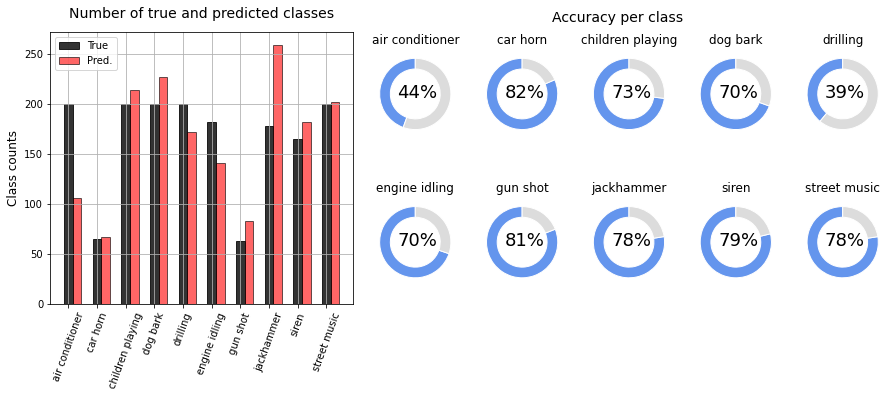

In [ ]:
plot_counts_accuracy(y_test, y_pred)

## Published RNN

-	We have used 2 LSTM layers with 128 hidden units in each. The layer requires output as a 3D array. First layer is provided with input of (20,5). Also, a dropout is used to avoid overfitting as much, with a value of 0.3.
-	In time distributed layer, the size of input for first layer is 128 with 256 number of nodes. For second layer, input size is 256 and 512 number of nodes. We have used ReLU activation function for both layers.
-	Output of time distributed dense layer (3D output) becomes input for flatten layer and the output is then passed to the last dense layer.
-	The outputs received from previous flatten layer are feed by dense layer to all 10 hidden layer neurons. At this layer we have used softmax activation function that gives output in terms of discrete probability distribution. 


In [ ]:
no_feats = 5

In [ ]:
XtrLSTM = x_train.reshape(x_train.shape[0], int(x_train.shape[1]/no_feats), no_feats) # (None, 40, 5)
XteLSTM = x_test.reshape(x_test.shape[0], int(x_test.shape[1]/no_feats), no_feats)

In [ ]:
'''
Published RNN model
'''

tf.random.set_seed(seed_value) # to get reproducible results

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(40, 5)))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(256,  activation="relu")))
model.add(TimeDistributed(Dense(512, activation="relu")))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))

#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 40, 128)           68608     
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 40, 128)           131584    
_________________________________________________________________
dropout_23 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 40, 256)           33024     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 40, 512)           131584    
_________________________________________________________________
flatten_7 (Flatten)          (None, 20480)           

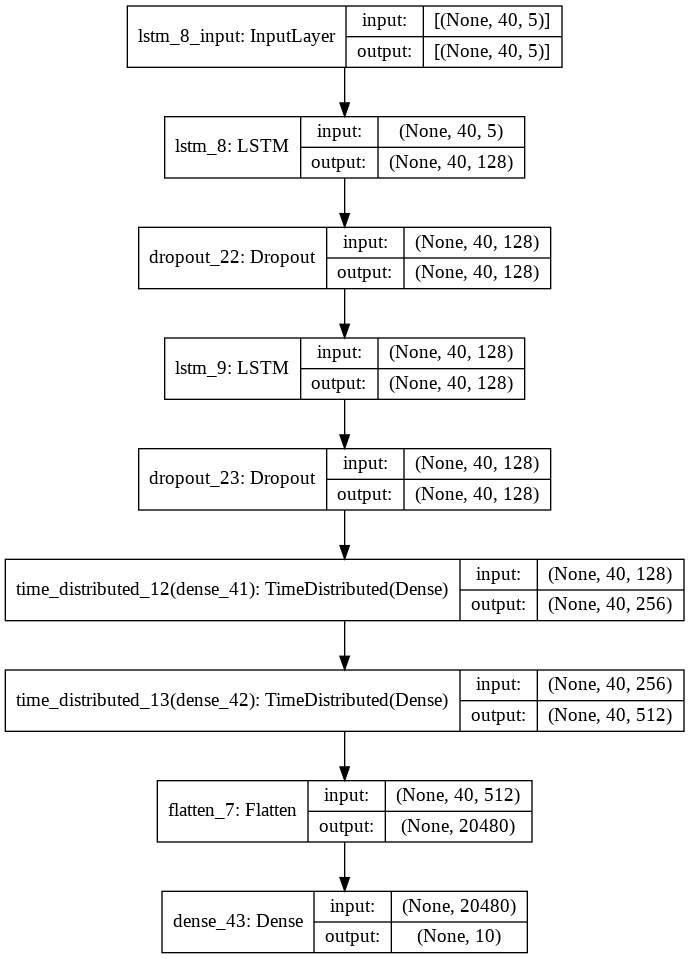

In [ ]:
# Display internal structure of layers and nodes

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
# model fitting
history = model.fit(XtrLSTM, y_train, validation_data=(XteLSTM, y_test), epochs=20, batch_size=30)

Epoch 1/20
267/267 [==============================] - 33s 111ms/step - loss: 1.9498 - accuracy: 0.2806 - val_loss: 1.6946 - val_accuracy: 0.4168
Epoch 2/20
267/267 [==============================] - 29s 108ms/step - loss: 1.2926 - accuracy: 0.5548 - val_loss: 1.4873 - val_accuracy: 0.4949
Epoch 3/20
267/267 [==============================] - 29s 109ms/step - loss: 1.0298 - accuracy: 0.6575 - val_loss: 1.4381 - val_accuracy: 0.5414
Epoch 4/20
267/267 [==============================] - 28s 106ms/step - loss: 0.8671 - accuracy: 0.7015 - val_loss: 1.4371 - val_accuracy: 0.5729
Epoch 5/20
267/267 [==============================] - 29s 108ms/step - loss: 0.6917 - accuracy: 0.7714 - val_loss: 1.3145 - val_accuracy: 0.6050
Epoch 6/20
267/267 [==============================] - 29s 108ms/step - loss: 0.5841 - accuracy: 0.8099 - val_loss: 1.3934 - val_accuracy: 0.6062
Epoch 7/20
267/267 [==============================] - 29s 107ms/step - loss: 0.4976 - accuracy: 0.8325 - val_loss: 1.4051 - val_ac

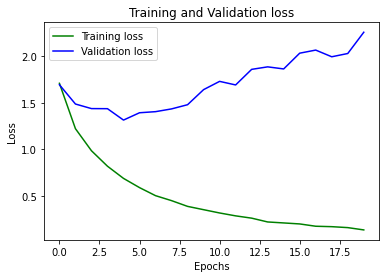

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

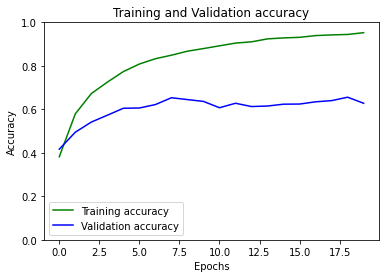

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteLSTM)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.627949  0.627949  0.627949
Macro   0.643723  0.640590  0.623999
***********************************************

Accuracy: 0.6279491833030852
***********************************************

Precision by class: [0.80722892 0.45528455 0.59545455 0.63541667 0.44628099 0.78285714
 0.68627451 0.70807453 0.66060606 0.65975104]


Recall by class: [0.335      0.86153846 0.655      0.61       0.54       0.75274725
 0.55555556 0.64044944 0.66060606 0.795     ]


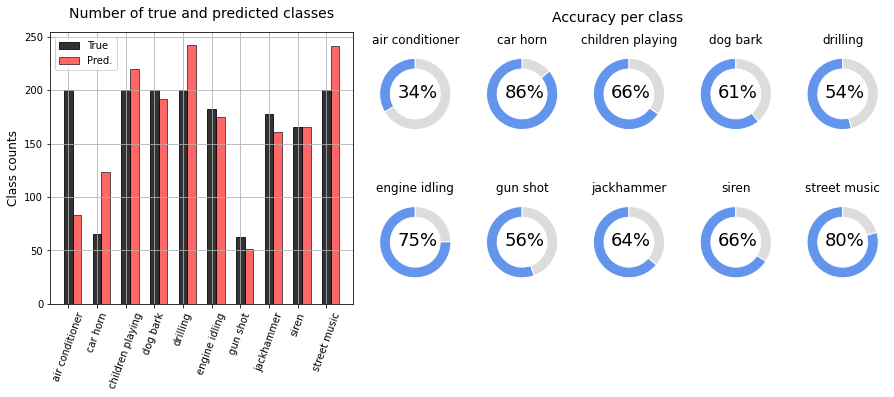

In [ ]:
plot_counts_accuracy(y_test, y_pred)

## Published CNN hat

In [ ]:
'''
This is a variation of published CNN model.

We tried to improve results by reducing overfitting. 
Additionally, no. of epochs was adjusted.

The following changes were applied:
1) Increased dropout rate: from 0.3 to 0.4
2) Model was simplified: no. of neurons in Dense layer changed from 512 to 256
3) Reduced batch size: from 50 to 20
'''

tf.random.set_seed(seed_value) # to get reproducible results

#forming model
model=Sequential()

#building the model
model.add(Conv2D(64, kernel_size = 5, strides=(1, 1), activation="relu", 
                 padding="same", input_shape=(XtrCNN.shape[1], XtrCNN.shape[2], 1)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 5, activation="relu", padding="same"))
model.add(Dropout(0.4)) # increasing dropout: 0.3 >> 0.4

model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=256,activation='relu')) # reducin no. of neurons: 512 >> 256
model.add(Dense(units=10,activation='softmax'))

#compiling
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
# model fitting  # batch size 50 >> 20, epochs 30 >> 10
history = model.fit(XtrCNN,y_train,epochs=20, validation_data=(XteCNN, y_test), batch_size=20)

Epoch 1/20
401/401 [==============================] - 14s 32ms/step - loss: 1.8851 - categorical_accuracy: 0.3023 - val_loss: 1.4088 - val_categorical_accuracy: 0.5481
Epoch 2/20
401/401 [==============================] - 13s 31ms/step - loss: 0.9862 - categorical_accuracy: 0.6548 - val_loss: 1.3034 - val_categorical_accuracy: 0.6038
Epoch 3/20
401/401 [==============================] - 13s 31ms/step - loss: 0.6921 - categorical_accuracy: 0.7731 - val_loss: 1.2084 - val_categorical_accuracy: 0.6394
Epoch 4/20
401/401 [==============================] - 13s 31ms/step - loss: 0.5402 - categorical_accuracy: 0.8214 - val_loss: 1.3215 - val_categorical_accuracy: 0.6261
Epoch 5/20
401/401 [==============================] - 13s 31ms/step - loss: 0.4401 - categorical_accuracy: 0.8602 - val_loss: 1.4020 - val_categorical_accuracy: 0.6249
Epoch 6/20
401/401 [==============================] - 12s 31ms/step - loss: 0.3463 - categorical_accuracy: 0.8868 - val_loss: 1.2896 - val_categorical_accuracy:

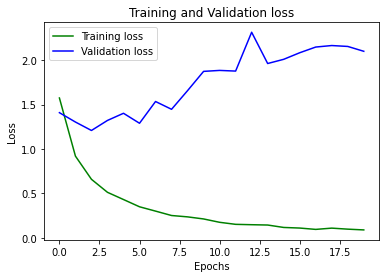

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

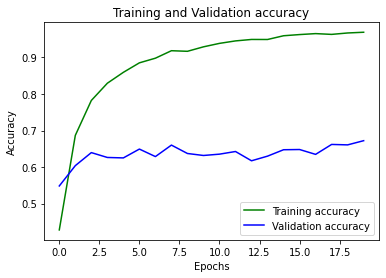

In [ ]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteCNN)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.672111  0.672111  0.672111
Macro   0.689318  0.694459  0.687054
***********************************************

Accuracy: 0.6721113127646703
***********************************************

Precision by class: [0.66257669 0.7012987  0.73544974 0.6984127  0.37628866 0.90070922
 0.72463768 0.53359684 0.8136646  0.74654378]


Recall by class: [0.54       0.83076923 0.695      0.66       0.365      0.6978022
 0.79365079 0.75842697 0.79393939 0.81      ]


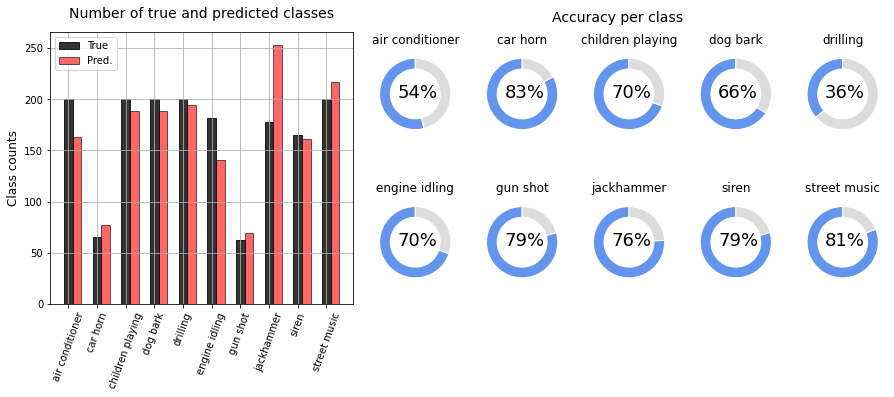

In [ ]:
plot_counts_accuracy(y_test, y_pred)

## Published RNN hat

In [ ]:
'''
This is a variation of published LSTM model.

We tried to improve results by reducing overfitting.
Additionally, no. of epochs was adjusted.

The following changes were applied:
1) Increased dropout rate: from 0.3 to 0.4
2) Reduced batch size: from 50 to 10
'''

tf.random.set_seed(seed_value) # to get reproducible results

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(40, 5))) # reducing
model.add(Dropout(0.4)) # dropout rate 0.4 >> 0.3
model.add(LSTM(128, return_sequences=True))

model.add(TimeDistributed(Dense(256, activation="relu")))
model.add(TimeDistributed(Dense(512, activation="relu")))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))

#compiling
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# model fitting # batch size 50 >> 10, epochs 30 >> 10
history = model.fit(XtrLSTM, y_train,epochs=10, validation_data=(XteLSTM, y_test), batch_size=10) 

Epoch 1/10
801/801 [==============================] - 65s 76ms/step - loss: 1.8182 - accuracy: 0.3473 - val_loss: 1.5132 - val_accuracy: 0.5033
Epoch 2/10
801/801 [==============================] - 62s 77ms/step - loss: 1.0665 - accuracy: 0.6419 - val_loss: 1.4167 - val_accuracy: 0.5868
Epoch 3/10
801/801 [==============================] - 60s 75ms/step - loss: 0.7545 - accuracy: 0.7572 - val_loss: 1.3982 - val_accuracy: 0.6044
Epoch 4/10
801/801 [==============================] - 60s 75ms/step - loss: 0.5779 - accuracy: 0.8125 - val_loss: 1.5297 - val_accuracy: 0.6158
Epoch 5/10
801/801 [==============================] - 61s 76ms/step - loss: 0.4603 - accuracy: 0.8439 - val_loss: 1.5876 - val_accuracy: 0.6110
Epoch 6/10
801/801 [==============================] - 61s 76ms/step - loss: 0.3815 - accuracy: 0.8740 - val_loss: 1.6575 - val_accuracy: 0.6092
Epoch 7/10
801/801 [==============================] - 61s 76ms/step - loss: 0.3234 - accuracy: 0.8920 - val_loss: 1.7146 - val_accuracy:

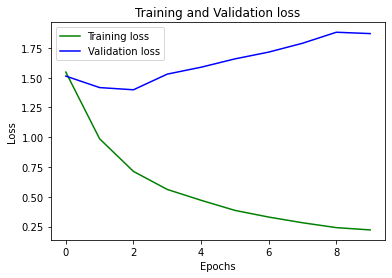

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

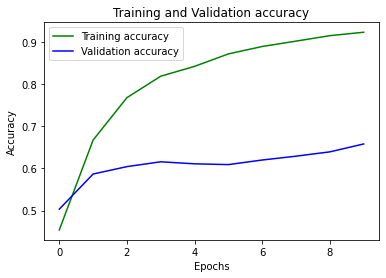

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# predictions
y_pred = model.predict(XteLSTM)

# metrics
dfresults, acc, recall_classes, precision_classes = my_results(y_test, y_pred)

In [ ]:
print('***********************************************')
print(dfresults)
print('***********************************************\n')
print('Accuracy: {}'.format(acc))
print('***********************************************\n')
print('Precision by class: {}'.format(precision_classes))
print('\n')
print('Recall by class: {}'.format(recall_classes))

***********************************************
       Precision    Recall  F1-score
Micro   0.658197  0.658197  0.658197
Macro   0.671530  0.668686  0.657891
***********************************************

Accuracy: 0.6581972171808832
***********************************************

Precision by class: [0.84848485 0.46774194 0.64159292 0.53070175 0.5026178  0.80368098
 0.71428571 0.67567568 0.84558824 0.68493151]


Recall by class: [0.56       0.89230769 0.725      0.605      0.48       0.71978022
 0.55555556 0.70224719 0.6969697  0.75      ]


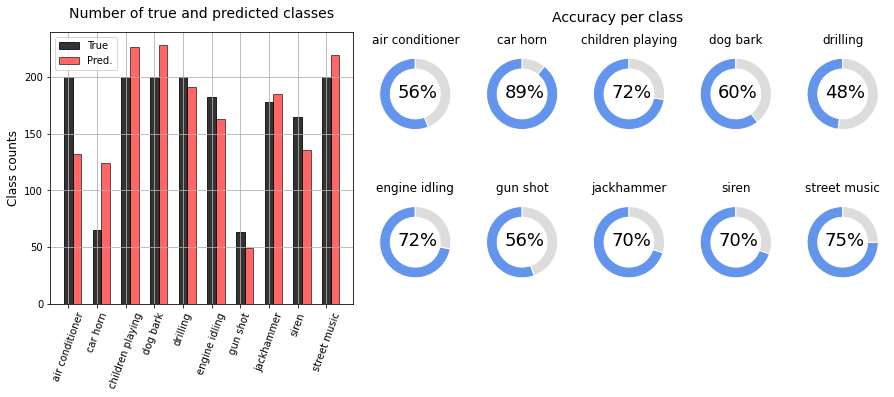

In [ ]:
plot_counts_accuracy(y_test, y_pred)

#References

Das J. K. et al. (2020). Urban Sound Classification Using Convolutional Neural Network and 
Long Short Term Memory Based on Multiple Features. Fourth International Conference On Intelligent Computing in Data Sciences (ICDS), pp. 1-9. doi: 10.1109/ICDS50568.2020.9268723


Salamon J. and Bello J. P. 2017. Deep Convolutional Neural Networks and Data Augmentation for 
Environmental Sound Classification. IEEE Signal Processing Letters 24(3), pp. 279-283. doi: 10.1109/LSP.2017.2657381



Useful links:

https://github.com/AmritK10/Urban-Sound-Classification/blob/master/Urban_data_preprocess.ipynb

https://towardsdatascience.com/urban-sound-classification-using-neural-networks-9b6fcd8a9150


https://arxiv.org/pdf/1608.04363


https://musicinformationretrieval.com/mfcc.html

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html


https://www.kaggle.com/mpwolke/who-let-the-dogs-out-wav




